# CSC 522 Project 
_by Team 21: Raphael Phillips (rjphill4), Sogolsadat Mansouri (smansou2), Rithik Jain (rjain25), and Neeloy Gomes (ntgomes)_

This project will involve developing a machine learning model using supervised learning to predict future exchange rates for a specific currency pair, based on historical exchange rate data and other relevant features.


In [72]:
# Run the python files needed for setting global variables/functions/classes for the notebook

%run pre_processing.py
%run lstm_rnn.py
%run rand_network_ensemble.py

In [91]:
# Import necessary libraries for the notebook

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPRegressor

In [74]:
# PREPROCESSING: Instantiate and clean the two input datasets

usdinr_df = pd.read_csv('../data/USDINRX.csv')
forex_df = pd.read_csv('../data/forex.csv')

print('Instantiated the input CSVs as dataframes')

cleaned_usdinr_df = pre_p_usdinr(usdinr_df)
cleaned_forex_df = pre_p_forex(forex_df)

print('Cleaned ' + str(len(forex_df.index) - len(cleaned_forex_df.index)) + ' rows from data/forex.csv')
print('Cleaned ' + str(len(usdinr_df.index) - len(cleaned_usdinr_df.index)) + ' rows from data/USDINRX.csv')

Instantiated the input CSVs as dataframes
Cleaned 1448456 rows from data/forex.csv
Cleaned 52 rows from data/USDINRX.csv


In [75]:
# PREPROCESSING: Merge the two input datasets

merged_df = merge(cleaned_forex_df, cleaned_usdinr_df)
print('Merged the two datasets')
merged_df

Merged the two datasets


,date,open,high,low,close
0,12387,45.709000,45.728001,45.615002,45.709999
1,12388,45.709000,45.719002,45.560001,45.629002
2,12389,45.632000,45.655998,45.474998,45.549999
3,12390,45.548000,45.612999,45.519001,45.548000
4,12391,45.549999,45.566002,45.449001,45.449001
...,...,...,...,...,...
9172,18890,73.696198,73.899597,73.607002,73.696098
9173,18891,73.659302,73.790100,73.549004,73.658997
9174,18892,73.795097,73.941498,73.650002,73.792702
9175,18893,73.875000,73.925797,73.588997,73.874901


In [76]:
# PREPROCESSING: Do the train test split on the merged dataset (50/50 due to limitations of the LSTM RNN)

merged_x_train, merged_x_test, merged_y_train, merged_y_test = split(merged_df)
print('Merged and did the train/test split of the datasets')

Merged and did the train/test split of the datasets


In [116]:
# PREPROCESSING: Sort the training and testing datasets by date (given the nature of the date variable)

merged_x_train = merged_x_train.sort_values(by=['date'])
merged_y_train = pd.concat([merged_x_train, merged_y_train], axis = 1).sort_values(by=['date'])['close']
merged_x_test = merged_x_test.sort_values(by=['date'])
merged_y_test = pd.concat([merged_x_test, merged_y_test], axis = 1).sort_values(by=['date'])['close']

In [117]:
# PREPROCESSING: Normalize the training and testing datasets for the processes of the LSTM RNN ensemble

x_train_scaler = MinMaxScaler()
x_train = pd.DataFrame(x_train_scaler.fit_transform(merged_x_train))

y_train_scaler = MinMaxScaler()
y_train = pd.DataFrame(y_train_scaler.fit_transform(merged_y_train.to_numpy().reshape(-1, 1)))

x_test_scaler = MinMaxScaler()
x_test = pd.DataFrame(x_test_scaler.fit_transform(merged_x_test))

y_test_scaler = MinMaxScaler()
y_test = pd.DataFrame(y_test_scaler.fit_transform(merged_y_test.to_numpy().reshape(-1, 1)))


In [118]:
# MODEL TRAINING: Instantiate and run the ensemble of random MLP regressors (baseline model)

mlpr_args = { 
    'activation': 'relu', 
    'hidden_layer_sizes': (50,), 
    'learning_rate_init': 0.01, 
    'random_state': 522 
} 
baseline_ensembler = RandomNetworkEnsemble(num_networks = 10, base_nn_model = MLPRegressor, model_args = mlpr_args, random_seed = 522)

baseline_ensembler.train(merged_x_train.to_numpy(), merged_y_train.to_numpy())
baseline_predictions = baseline_ensembler.predict(merged_x_test.to_numpy())

array([45.76519901, 45.66075629, 45.62071468, ..., 72.60947019,
       72.60049315, 72.58431125])

In [121]:
# MODEL TRAINING: Instantiate and run the ensemble of random LSTM RNNs

lstm_args = { 
    "input_shape": (len(x_train.to_numpy()), len(x_train.to_numpy()[0])), 
    "lstm_units": 32, 
    "dense_units": 16, 
    "output_shape": (1,) 
}
ensembler = RandomNetworkEnsemble(num_networks = 10, base_nn_model = CustomLSTM, model_args = lstm_args, random_seed = 522)

ensembler.train(x_train.to_numpy(), y_train.to_numpy())
predicted_target = ensembler.predict(x_test.to_numpy())

Epoch 1/10
Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.3001
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.2680
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.2443
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.2129
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.1759
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.1388
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.1072
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0930
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0976
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.1135
Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.2942
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.2690
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.2510


In [122]:
# EVALUATION: Printing some stats from the predictions
print('RMSE of tuned baseline model\'s predictions: ' + str(baseline_ensembler.calculate_rmse_of_predicted(merged_y_test.to_numpy())))
print('RMSE of tuned LSTM model\'s predictions: ' + str(ensembler.calculate_rmse_of_predicted(y_test.to_numpy())))

RMSE of tuned baseline model's predictions: 1.9103364168906962
RMSE of tuned LSTM model's predictions: 0.1303768195233431


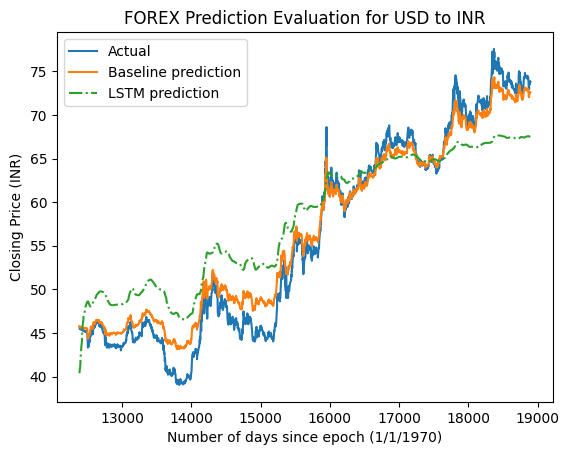

In [125]:
# EVALUATION: Making a line chart of the predicted versus the actual
#   (inverse normalizing on the LSTM predicted to adhere to the context)

plt.plot(merged_x_test['date'], merged_y_test, label ='Actual')
plt.plot(merged_x_test['date'], baseline_predictions.reshape(-1, 1).ravel(), label ='Baseline prediction')
plt.plot(merged_x_test['date'], y_test_scaler.inverse_transform(predicted_target.reshape(-1, 1)).ravel(), '-.', label ='LSTM prediction')

plt.xlabel('Number of days since epoch (1/1/1970)')
plt.ylabel('Closing Price (INR)')
plt.legend()
plt.title('FOREX Prediction Evaluation for USD to INR')
plt.show()